In [ ]:
# Test the XRT that is available;
# https://umbra.nascom.nasa.gov/hinode/xrt/level1/2022/09/06/H2100/
# 
# No Al-Poly in this directory (or online??) have 117 of them in this hour - but very short exposure 0.004, 
# low res and full view but centred on this AR, so not showing much anyway?
#  
# There is also EIS for this event as well .....
# 
# Summary of data here: https://sdc.uio.no/search/result?P=1;INSTRUME=,EIS,XRT;EPOCH_START=2022-09-06+21%3A00;EPOCH_END=%2B1+hour;el=,,192.82,195.12,256.32;en=10;ep=V;s=,FILE,INSTRUME,DATE_OBS,X__EC_FW1_,EXPTIME;c_s=y;th=y;SS__L1LEAD=y;si=,c,a,b,d;G=IUMODE1;Gx=NONE;O=DATE_OBS;o=D;L=10;j=y
# 
# 
# 23-Apr-2025 IGH

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib import animation
from IPython.display import HTML
import scipy.io as io
import glob
import gc
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

import warnings
warnings.simplefilter('ignore')
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular"})

In [3]:
# find all the files
fdir='/users/iain/Desktop/xrt_level1/umbra.nascom.nasa.gov/hinode/xrt/level1/2022/09/06/H2100/'
ff=sorted(glob.glob(fdir+'*.fits'))

nf=len(ff)
print(nf)

180


In [4]:
# Just loop over all the files to check the info per file
exptims=[]
dates=[]
nxs=[]
filters=[]
lnames=[]

for fname in ff:
    a_temp=sunpy.map.Map(fname)
    exptims.append(a_temp.exposure_time.value)
    dates.append(a_temp.date)
    nxs.append(a_temp.dimensions[0].value)
    lnames.append(a_temp.latex_name)
    filters.append(a_temp.measurement)
    del a_temp
    gc.collect()

exptims=np.array(exptims)
dates=np.array(dates)
nxs=np.array(nxs)
filters=np.array(filters)
lnames=np.array(lnames)

In [5]:
# Find the Be Thin and Be Med ones
idt=np.where(filters == "Be thin-Open")[0]
# Longer exposure of thin is just saturated so can remove as well
idt_ns=np.where((filters == "Be thin-Open") & (exptims < 2))[0]
idm=np.where(filters == "Be med-Open")[0]
print(len(idt))
print(len(idt_ns))
print(len(idm))

# for i in idt:
#     print(filters[i],exptims[i],nxs[i])

# for i in idm:
#     print(filters[i],exptims[i],nxs[i])

120
60
60


In [6]:
# Files of each filter type
xrt_fm=[ff[i] for i in idm]
xrt_ft=[ff[i] for i in idt]
xrt_ft_ns=[ff[i] for i in idt_ns]

In [7]:
# Make a Be Med movie so load them all in and submap
bl=[800 * u.arcsec, -470 * u.arcsec]
tr=[950 * u.arcsec, -320 * u.arcsec]

nrm=ImageNormalize(vmin=0, vmax=5e3, stretch=SqrtStretch())

xtemp=sunpy.map.Map(xrt_fm)
xrtsm=[]
for x in xtemp:
    xm=sunpy.map.Map(x)
    bottom_left = SkyCoord(bl[0], bl[1] , frame=xm.coordinate_frame)
    top_right = SkyCoord(tr[0], tr[1], frame=xm.coordinate_frame)
    xms=xm.submap(bottom_left=bottom_left, top_right=top_right)
    # xms.plot(norm=nrm)
    # fexp=f'{xm.exposure_time.value:.2f}'
    # plt.title(xm.measurement[:6]+' ('+x.date.isot[11:19]+','+fexp+'s)')
    # plt.colorbar(label='DN/s')
    # plt.show()
    xrtsm.append(xms)

# xtemp.clear()


In [8]:
plt.rcParams['font.size'] = 16
cm_got_hx=plt.get_cmap('hinodexrt')

# fig, ax = plt.subplots()
fig = plt.figure(figsize=[9,7])
ax = plt.subplot(projection=xrtsm[0])
# plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# image half down sequence to get better scaling
norm = colors.PowerNorm(0.25,vmin=1e1,vmax=5e3)
# norm = colors.LogNorm(vmin=10,vmax=5e3)
# norm=ImageNormalize(vmin=0, vmax=5e3, stretch=SqrtStretch())
# norm=ImageNormalize(vmin=0, vmax=4e3, stretch=AsinhStretch())

plot_obj = xrtsm[0].plot(norm=norm,cmap=cm_got_hx)

ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
plt.colorbar(label='DN/s',fraction=0.046, pad=0.04)

def animate(i):
    fexp=f'{xrtsm[i].exposure_time.value:.2f}'
    ax.set_title(xrtsm[i].measurement[:6]+' ('+xrtsm[i].date.isot[11:19]+','+fexp+'s)')
    plot_obj.set_data(xrtsm[i].data)
    return (plot_obj,)

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=len(xrtsm), interval=200, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

In [9]:
# Make a Be Thin movie so load them all in and submap
# Only use shorter exposure ones
bl=[800 * u.arcsec, -470 * u.arcsec]
tr=[950 * u.arcsec, -320 * u.arcsec]


xtemp=sunpy.map.Map(xrt_ft_ns)
xrtsm=[]
for x in xtemp:
    xm=sunpy.map.Map(x)
    bottom_left = SkyCoord(bl[0], bl[1] , frame=xm.coordinate_frame)
    top_right = SkyCoord(tr[0], tr[1], frame=xm.coordinate_frame)
    xms=xm.submap(bottom_left=bottom_left, top_right=top_right)
    xrtsm.append(xms)

# xtemp.clear()


In [10]:
# Constant normalisation
plt.rcParams['font.size'] = 16
cm_got_hx=plt.get_cmap('hinodexrt')

# fig, ax = plt.subplots()
fig = plt.figure(figsize=[9,7])
ax = plt.subplot(projection=xrtsm[0])
# plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# image half down sequence to get better scaling
norm = colors.PowerNorm(0.25,vmin=1e1,vmax=7e3)
# norm = colors.LogNorm(vmin=10,vmax=5e3)
# norm=ImageNormalize(vmin=0, vmax=5e3, stretch=SqrtStretch())
# norm=ImageNormalize(vmin=0, vmax=4e3, stretch=AsinhStretch())

plot_obj = xrtsm[0].plot(norm=norm,cmap=cm_got_hx)

ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
plt.colorbar(label='DN/s',fraction=0.046, pad=0.04)

def animate(i):
    fexp=f'{xrtsm[i].exposure_time.value:.2f}'
    ax.set_title(xrtsm[i].measurement[:7]+' ('+xrtsm[i].date.isot[11:19]+','+fexp+'s)')
    plot_obj.set_data(xrtsm[i].data)
    return (plot_obj,)

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=len(xrtsm), interval=200, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

In [11]:
# Given the exposure time changes so much vary the scaling
plt.rcParams['font.size'] = 16
cm_got_hx=plt.get_cmap('hinodexrt')

# fig, ax = plt.subplots()
fig = plt.figure(figsize=[9,7])
ax = plt.subplot(projection=xrtsm[0])
# plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)

# image half down sequence to get better scaling
norm = colors.PowerNorm(0.25,vmin=1e1,vmax=5e3)
# norm = colors.LogNorm(vmin=10,vmax=5e3)
# norm=ImageNormalize(vmin=0, vmax=5e3, stretch=SqrtStretch())
# norm=ImageNormalize(vmin=0, vmax=4e3, stretch=AsinhStretch())

plot_obj = xrtsm[0].plot(norm=norm,cmap=cm_got_hx)

ax.set_ylabel('y [arcsec]')
ax.set_xlabel('x [arcsec]')
tx, ty = ax.coords
tx.set_major_formatter('s')
ty.set_major_formatter('s')
ax.grid(False)
plt.colorbar(label='DN/s',fraction=0.046, pad=0.04)

def animate(i):
    fexp=f'{xrtsm[i].exposure_time.value:.2f}'
    ax.set_title(xrtsm[i].measurement[:7]+' ('+xrtsm[i].date.isot[11:19]+','+fexp+'s)')
    plot_obj.set_data(xrtsm[i].data)
    norm = colors.PowerNorm(0.25,vmin=1e1,vmax=1.1*np.max(xrtsm[i].data))
    plot_obj.set_norm(norm)
    plot_obj.set_clim(vmin=1e1, vmax=1.1*np.max(xrtsm[i].data))
    return (plot_obj,)

anim = animation.FuncAnimation(fig, animate, init_func=None,
                               frames=len(xrtsm), interval=200, blit=True)
plt.close(fig)
HTML(anim.to_html5_video())

In [28]:
# What do the temperature responses of these two channels look like?
# Can now get this via xrtpy
import xrtpy


date_time = "2022-09-06T21:30:00"
tpf = xrtpy.response.TemperatureResponseFundamental("Be-Thin", date_time, abundance_model="Coronal")

temps=tpf.CHIANTI_temperature.to_value()
tr_thin=tpf.temperature_response()

tpf = xrtpy.response.TemperatureResponseFundamental("Be-Med", date_time, abundance_model="Coronal")
tr_med=tpf.temperature_response()


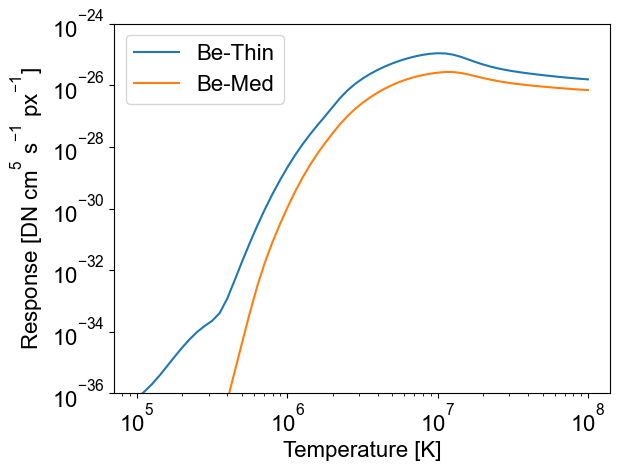

In [36]:
plt.loglog(temps,tr_thin,label='Be-Thin')
plt.loglog(temps,tr_med,label='Be-Med')
plt.gca().set_xlabel('Temperature [K]')
plt.gca().set_ylabel('Response [DN cm$^{5}$ s$^{-1}$ px$^{-1}$]')
plt.ylim([1e-36,1e-24])
plt.legend()
plt.show()